Note:  
This notebook was executed on google colab pro.

In [ ]:
!pip3 install pytorch-lightning --quiet

     |████████████████████████████████| 813 kB 15.0 MB/s 
     |████████████████████████████████| 118 kB 24.2 MB/s 
     |████████████████████████████████| 829 kB 25.2 MB/s 
     |████████████████████████████████| 636 kB 53.4 MB/s 
     |████████████████████████████████| 234 kB 61.6 MB/s 
     |████████████████████████████████| 10.6 MB 59.1 MB/s 
     |████████████████████████████████| 1.3 MB 59.2 MB/s 
     |████████████████████████████████| 294 kB 53.5 MB/s 
     |████████████████████████████████| 142 kB 69.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires tensorboard~=2.5, but you have tensorboard 2.4.1 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/atmacup11/experiments')

# Settings

In [ ]:
EXP_NO = 15
SEED = 1
N_SPLITS = 5
TARGET = 'target'
GROUP = 'art_series_id'
REGRESSION = True

In [ ]:
assert((TARGET, REGRESSION) in (('target', True), ('target', False), ('sorting_date', True)))

In [ ]:
MODEL_NAME = 'squeezenet'
BATCH_SIZE = 128
NUM_EPOCHS = 50

# Library

In [ ]:
from collections import defaultdict
from functools import partial
import gc
import glob
import json
from logging import getLogger, StreamHandler, FileHandler, DEBUG, Formatter
import pickle
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error, cohen_kappa_score
# from sklearnex import patch_sklearn
from pytorch_lightning import seed_everything
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
from torchvision import transforms

SCRIPTS_DIR = os.path.join('..', 'scripts')
assert(os.path.isdir(SCRIPTS_DIR))
if SCRIPTS_DIR not in sys.path: sys.path.append(SCRIPTS_DIR)

from cross_validation import load_cv_object_ids
from dataset import load_csvfiles, load_photofile,load_photofiles, AtmaImageDatasetV02
from folder import experiment_dir_of
from models import initialize_model
from utils import train_model, predict_by_model

In [ ]:
pd.options.display.float_format = '{:.5f}'.format

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

# Prepare directory

In [ ]:
output_dir = experiment_dir_of(EXP_NO)

In [ ]:
output_dir

'../scripts/../experiments/exp015'

# Prepare logger

In [ ]:
logger = getLogger(__name__)

In [ ]:
'''Refference
https://docs.python.org/ja/3/howto/logging-cookbook.html
'''
logger.setLevel(DEBUG)
# create file handler which logs even debug messages
fh = FileHandler(os.path.join(output_dir, 'log.log'))
fh.setLevel(DEBUG)
# create console handler with a higher log level
ch = StreamHandler()
ch.setLevel(DEBUG)
# create formatter and add it to the handlers
formatter = Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)
len(logger.handlers)

2

In [ ]:
logger.info('Experiment no: {}'.format(EXP_NO))
logger.info('CV: StratifiedGroupKFold')
logger.info('SEED: {}'.format(SEED))
logger.info('REGRESSION: {}'.format(REGRESSION))

2021-07-20 19:52:29,631 - __main__ - INFO - Experiment no: 15
2021-07-20 19:52:29,634 - __main__ - INFO - CV: StratifiedGroupKFold
2021-07-20 19:52:29,637 - __main__ - INFO - SEED: 1
2021-07-20 19:52:29,639 - __main__ - INFO - REGRESSION: True


# Load csv files

In [ ]:
SINCE = time.time()

In [ ]:
logger.debug('Start loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))
train, test, materials, techniques, sample_submission = load_csvfiles()
logger.debug('Complete loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-20 19:52:29,659 - __main__ - DEBUG - Start loading csv files (0.010 seconds passed)
2021-07-20 19:52:32,105 - __main__ - DEBUG - Complete loading csv files (2.457 seconds passed)


In [ ]:
train

,object_id,sorting_date,art_series_id,target
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3
...,...,...,...,...
3932,ffa3259fff8e6f3818a1,1850,b187c294b0550acf049a,3
3933,ffd4d361756587883e48,1670,ad49a044770a48f860a6,1
3934,ffd794b7b311b7b7fd92,1789,f030a01b480b18a27be2,2
3935,ffe49bba69d06446de7e,1805,f5287bc84a05aada1d17,3


In [ ]:
test

,object_id
0,0009e50b94be36ccad39
1,000bd5e82eb22f199f44
2,0015f44de1854f617516
3,00388a678879ba1efa27
4,005e1e7c6496902d23f3
...,...
5914,ffbe65ad399b632dcbd0
5915,ffd7b2d646c0320c311a
5916,ffdb93ede17d4501e530
5917,ffe111402004b0ed46b4


# Cross validation

In [ ]:
seed_everything(SEED)

Global seed set to 1


1

In [ ]:
train.set_index('object_id', inplace=True)

2021-07-20 19:52:32,914 - __main__ - DEBUG - Start fold 1 (3.266 seconds passed)
2021-07-20 19:52:32,920 - __main__ - DEBUG - Start training model (3.272 seconds passed)
2021-07-20 19:52:39,716 - __main__ - DEBUG - Epoch 0/49
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
2021-07-20 20:06:35,128 - __main__ - DEBUG - train Loss: 10.6055
2021-07-20 20:09:59,313 - __main__ - DEBUG - val Loss: 1.0529
2021-07-20 20:09:59,324 - __main__ - DEBUG - Epoch 1/49
2021-07-20 20:10:09,973 - __main__ - DEBUG - train Loss: 1.0861
2021-07-20 20:10:12,625 - __main__ - DEBUG - val Loss: 0.9672
2021-07-20 20:10:12,633 - __main__ - DEBUG - Epoch 2/49
2021-

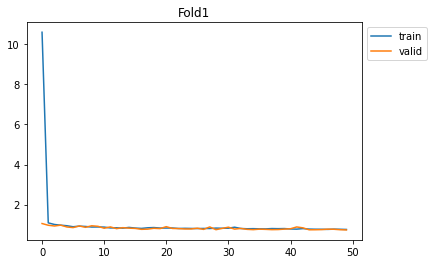

2021-07-20 20:45:34,578 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp015/cv_fold1_training.csv (3184.930 seconds passed)
2021-07-20 20:45:34,591 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp015/cv_fold1_validation.csv (3184.943 seconds passed)
2021-07-20 20:45:34,613 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp015/cv_fold1_test.csv (3184.965 seconds passed)
2021-07-20 20:45:34,646 - __main__ - DEBUG - Save model ../scripts/../experiments/exp015/cv_fold1_model.torch (3184.997 seconds passed)
2021-07-20 20:45:34,750 - __main__ - DEBUG - Complete fold 1 (3185.101 seconds passed)
2021-07-20 20:45:34,752 - __main__ - DEBUG - Start fold 2 (3185.103 seconds passed)
2021-07-20 20:45:34,761 - __main__ - DEBUG - Start training model (3185.113 seconds passed)
2021-07-20 20:45:34,795 - __main__ - DEBUG - Epoch 0/49
2021-07-20 20:45:45,619 - __main__ - DEBUG - train Loss: 7.5673
2021-07-20 20:45:48,338 - __main__ - DEBUG

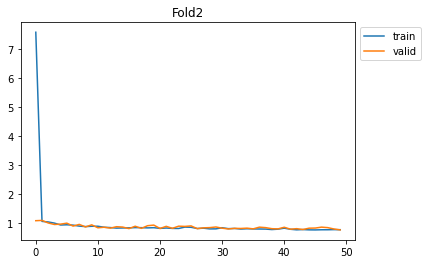

2021-07-20 20:57:22,032 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp015/cv_fold2_training.csv (3892.383 seconds passed)
2021-07-20 20:57:22,048 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp015/cv_fold2_validation.csv (3892.399 seconds passed)
2021-07-20 20:57:22,072 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp015/cv_fold2_test.csv (3892.423 seconds passed)
2021-07-20 20:57:22,098 - __main__ - DEBUG - Save model ../scripts/../experiments/exp015/cv_fold2_model.torch (3892.450 seconds passed)
2021-07-20 20:57:22,204 - __main__ - DEBUG - Complete fold 2 (3892.556 seconds passed)
2021-07-20 20:57:22,207 - __main__ - DEBUG - Start fold 3 (3892.559 seconds passed)
2021-07-20 20:57:22,215 - __main__ - DEBUG - Start training model (3892.567 seconds passed)
2021-07-20 20:57:22,251 - __main__ - DEBUG - Epoch 0/49
2021-07-20 20:57:32,868 - __main__ - DEBUG - train Loss: 4.2874
2021-07-20 20:57:35,691 - __main__ - DEBUG

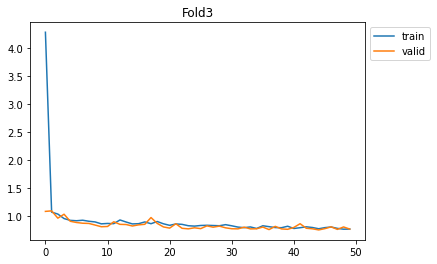

2021-07-20 21:09:04,644 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp015/cv_fold3_training.csv (4594.995 seconds passed)
2021-07-20 21:09:04,657 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp015/cv_fold3_validation.csv (4595.009 seconds passed)
2021-07-20 21:09:04,680 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp015/cv_fold3_test.csv (4595.031 seconds passed)
2021-07-20 21:09:04,704 - __main__ - DEBUG - Save model ../scripts/../experiments/exp015/cv_fold3_model.torch (4595.055 seconds passed)
2021-07-20 21:09:04,798 - __main__ - DEBUG - Complete fold 3 (4595.150 seconds passed)
2021-07-20 21:09:04,801 - __main__ - DEBUG - Start fold 4 (4595.153 seconds passed)
2021-07-20 21:09:04,813 - __main__ - DEBUG - Start training model (4595.164 seconds passed)
2021-07-20 21:09:04,844 - __main__ - DEBUG - Epoch 0/49
2021-07-20 21:09:15,336 - __main__ - DEBUG - train Loss: 8.3669
2021-07-20 21:09:18,009 - __main__ - DEBUG

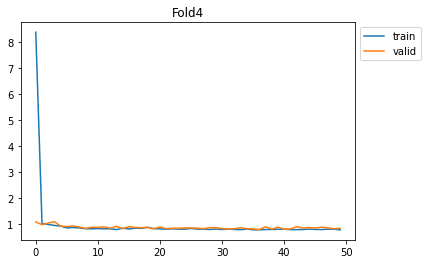

2021-07-20 21:20:53,589 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp015/cv_fold4_training.csv (5303.941 seconds passed)
2021-07-20 21:20:53,603 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp015/cv_fold4_validation.csv (5303.954 seconds passed)
2021-07-20 21:20:53,626 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp015/cv_fold4_test.csv (5303.978 seconds passed)
2021-07-20 21:20:53,651 - __main__ - DEBUG - Save model ../scripts/../experiments/exp015/cv_fold4_model.torch (5304.003 seconds passed)
2021-07-20 21:20:53,746 - __main__ - DEBUG - Complete fold 4 (5304.098 seconds passed)
2021-07-20 21:20:53,748 - __main__ - DEBUG - Start fold 5 (5304.100 seconds passed)
2021-07-20 21:20:53,755 - __main__ - DEBUG - Start training model (5304.107 seconds passed)
2021-07-20 21:20:53,795 - __main__ - DEBUG - Epoch 0/49
2021-07-20 21:21:04,707 - __main__ - DEBUG - train Loss: 61.9566
2021-07-20 21:21:07,369 - __main__ - DEBU

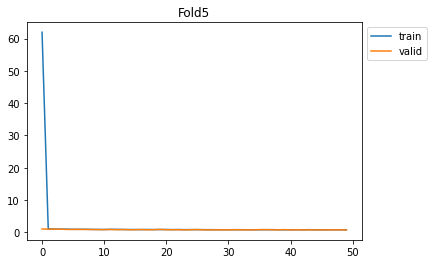

2021-07-20 21:32:31,993 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp015/cv_fold5_training.csv (6002.344 seconds passed)
2021-07-20 21:32:32,007 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp015/cv_fold5_validation.csv (6002.359 seconds passed)
2021-07-20 21:32:32,031 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp015/cv_fold5_test.csv (6002.382 seconds passed)
2021-07-20 21:32:32,055 - __main__ - DEBUG - Save model ../scripts/../experiments/exp015/cv_fold5_model.torch (6002.406 seconds passed)
2021-07-20 21:32:32,152 - __main__ - DEBUG - Complete fold 5 (6002.503 seconds passed)


In [ ]:
fold_object_ids = load_cv_object_ids()
for i, (train_object_ids, valid_object_ids) in enumerate(zip(fold_object_ids[0], fold_object_ids[1])):
    assert(set(train_object_ids) & set(valid_object_ids) == set())
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

    # Separate dataset into training/validation fold
    y_train = train.loc[train_object_ids, TARGET].values
    y_valid = train.loc[valid_object_ids, TARGET].values
    
    # Training
    logger.debug('Start training model ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## Prepare model
    model, input_size = initialize_model(MODEL_NAME)
    model.to(DEVICE)
    ## Prepare transformers
    train_transformer = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_transformer = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    # Prepare dataset
    train_dataset = AtmaImageDatasetV02(train_object_ids, train_transformer, y_train)
    val_dataset = AtmaImageDatasetV02(valid_object_ids, val_transformer, y_valid)
    # Prepare dataloader
    dataloaders = {
        'train': DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count()),
        'val': DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count()),
    }
    ## train estimator
    estimator, train_losses, valid_losses = train_model(
        model, dataloaders, criterion=nn.MSELoss(), num_epochs=NUM_EPOCHS, device=DEVICE,
        optimizer=torch.optim.Adam(model.parameters()), log_func=logger.debug,
        is_inception=MODEL_NAME == 'inception')
    logger.debug('Complete training ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## Visualize training loss
    plt.plot(train_losses, label='train')
    plt.plot(valid_losses, label='valid')
    plt.legend(loc='upper left', bbox_to_anchor=[1., 1.])
    plt.title(f'Fold{num_fold}')
    plt.show()
    
    # Save model and prediction
    ## Prediction
    if REGRESSION:
        predictions = {}
        for fold_, object_ids_ in zip(['train', 'val', 'test'],
                                     [train_object_ids, valid_object_ids, test['object_id']]):
            # Prepare transformer
            transformer_ = transforms.Compose([
                transforms.Resize(input_size),
                transforms.CenterCrop(input_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            # Prepare dataset
            dataset_ = AtmaImageDatasetV02(object_ids_, transformer_)
            # Prepare dataloader
            dataloader_ = DataLoader(dataset=dataset_, batch_size=BATCH_SIZE, shuffle=False,
                                     num_workers=os.cpu_count())
            # Prediction
            predictions[fold_] = predict_by_model(estimator, dataloader_, DEVICE)
        pred_train = pd.DataFrame(data=predictions['train'], columns=['pred'])
        pred_valid = pd.DataFrame(data=predictions['val'], columns=['pred'])
        pred_test = pd.DataFrame(data=predictions['test'], columns=['pred'])
    else:  # Do not come here!
        raise NotImplemented
        try:
            pred_train = pd.DataFrame(data=estimator.predict_proba(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.predict_proba(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.predict_proba(X_test),
                                     columns=estimator.classes_)
        except AttributeError:
            pred_train = pd.DataFrame(data=estimator.decision_function(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.decision_function(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.decision_function(X_test),
                                     columns=estimator.classes_)
    ## Training set
    pred_train['object_id'] = train_object_ids
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train.to_csv(filepath_fold_train, index=False)
    logger.debug('Save training fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_train, time.time() - SINCE))
    ## Validation set
    pred_valid['object_id'] = valid_object_ids
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid.to_csv(filepath_fold_valid, index=False)
    logger.debug('Save validation fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_valid, time.time() - SINCE))
    ## Test set
    pred_test['object_id'] = test['object_id'].values
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test.to_csv(filepath_fold_test, index=False)
    logger.debug('Save test result {} ({:.3f} seconds passed)' \
                 .format(filepath_fold_test, time.time() - SINCE))
    ## Model
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.torch')
    torch.save(estimator.state_dict(), filepath_fold_model)
#     with open(filepath_fold_model, 'wb') as f:
#         pickle.dump(estimator, f)
    logger.debug('Save model {} ({:.3f} seconds passed)'.format(filepath_fold_model, time.time() - SINCE))
    
    # Save memory
    del (estimator, y_train, y_valid, pred_train, pred_valid, pred_test)
    gc.collect()

    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

# Evaluation

In [ ]:
rmse = partial(mean_squared_error, squared=False)

In [ ]:
# qwk = partial(cohen_kappa_score, labels=np.sort(train['target'].unique()), weights='quadratic')

In [ ]:
@np.vectorize
def predict(proba_0: float, proba_1: float, proba_2: float, proba_3: float) -> int:
    return np.argmax((proba_0, proba_1, proba_2, proba_3))

In [ ]:
metrics = defaultdict(list)

## Training set

In [ ]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (training set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train_df = pd.read_csv(filepath_fold_train)
    pred_train_df['actual'] = train.loc[pred_train_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_train_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_train_df['pred'] = np.vectorize(soring_date2target)(pred_train_df['pred'])
            pred_train_df['actual'] = np.vectorize(soring_date2target)(pred_train_df['actual'])
    else:
        pred_train_df['pred'] = predict(pred_train_df['0'], pred_train_df['1'],
                                        pred_train_df['2'], pred_train_df['3'])
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_train_df['actual'], pred_train_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_train_df['actual'], pred_train_df['pred'])
#     score = qwk(pred_train_df['actual'], pred_train_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['train_losses'].append(loss)
#     metrics['train_scores'].append(score)
    pred_train_dfs.append(pred_train_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])
# metrics['train_scores_avg'] = np.mean(metrics['train_scores'])
# metrics['train_scores_std'] = np.std(metrics['train_scores'])

2021-07-20 21:32:32,218 - __main__ - DEBUG - Evaluate cv result (training set) Fold 1
2021-07-20 21:32:32,253 - __main__ - DEBUG - Loss: 0.8381419585637506
2021-07-20 21:32:32,258 - __main__ - DEBUG - Evaluate cv result (training set) Fold 2
2021-07-20 21:32:32,271 - __main__ - DEBUG - Loss: 0.842850645120072
2021-07-20 21:32:32,272 - __main__ - DEBUG - Evaluate cv result (training set) Fold 3
2021-07-20 21:32:32,286 - __main__ - DEBUG - Loss: 0.8703393965065244
2021-07-20 21:32:32,287 - __main__ - DEBUG - Evaluate cv result (training set) Fold 4
2021-07-20 21:32:32,300 - __main__ - DEBUG - Loss: 0.8445331759398275
2021-07-20 21:32:32,301 - __main__ - DEBUG - Evaluate cv result (training set) Fold 5
2021-07-20 21:32:32,314 - __main__ - DEBUG - Loss: 0.8490899252458026


In [ ]:
pred_train = pd.concat(pred_train_dfs).groupby('object_id').sum()
pred_train = pred_train / N_SPLITS
if not REGRESSION:
    pred_train['pred'] = predict(pred_train['0'], pred_train['1'], pred_train['2'], pred_train['3'])
pred_train['actual'] = train.loc[pred_train.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_train['actual'] = np.vectorize(soring_date2target)(pred_train['actual'])
# for c in ('pred', 'actual'):
#     pred_train[c] = pred_train[c].astype('int')
pred_train

,pred,actual
object_id,,
002bff09b09998d0be65,1.23631,1
00309fb1ef05416f9c1f,1.64315,3
003a1562e97f79ba96dc,1.76967,3
004890880e8e7431147b,1.01919,2
00718c32602425f504c1,1.70842,3
...,...,...
ffa3259fff8e6f3818a1,1.79444,3
ffd4d361756587883e48,0.79203,1
ffd794b7b311b7b7fd92,1.63877,2


In [ ]:
if not (REGRESSION and TARGET == 'target'):
    print(confusion_matrix(pred_train['actual'], pred_train['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_train['actual'], pred_train['pred'])
# score = qwk(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = loss
# metrics['train_score'] = score
logger.info('Training loss: {}'.format(loss))
# logger.info('Training score: {}'.format(score))

2021-07-20 21:32:32,376 - __main__ - INFO - Training loss: 0.9268935919136302


In [ ]:
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_train.csv')))

2021-07-20 21:32:32,416 - __main__ - DEBUG - Write cv result to ../scripts/../experiments/exp015/prediction_train.csv


## Validation set

In [ ]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (validation set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid_df = pd.read_csv(filepath_fold_valid)
    pred_valid_df['actual'] = train.loc[pred_valid_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_valid_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_valid_df['pred'] = np.vectorize(soring_date2target)(pred_valid_df['pred'])
            pred_valid_df['actual'] = np.vectorize(soring_date2target)(pred_valid_df['actual'])
    else:
        pred_valid_df['pred'] = predict(pred_valid_df['0'], pred_valid_df['1'],
                                        pred_valid_df['2'], pred_valid_df['3'])        
    
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_valid_df['actual'], pred_valid_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_valid_df['actual'], pred_valid_df['pred'])
#     score = qwk(pred_valid_df['actual'], pred_valid_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['valid_losses'].append(loss)
#     metrics['valid_scores'].append(score)
    pred_valid_dfs.append(pred_valid_df)
    
metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])
# metrics['valid_scores_avg'] = np.mean(metrics['valid_scores'])
# metrics['valid_scores_std'] = np.std(metrics['valid_scores'])

2021-07-20 21:32:32,446 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 1
2021-07-20 21:32:32,462 - __main__ - DEBUG - Loss: 0.8567197799595209
2021-07-20 21:32:32,463 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 2
2021-07-20 21:32:32,475 - __main__ - DEBUG - Loss: 0.881793653584724
2021-07-20 21:32:32,476 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 3
2021-07-20 21:32:32,497 - __main__ - DEBUG - Loss: 0.8699166054069178
2021-07-20 21:32:32,501 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 4
2021-07-20 21:32:32,518 - __main__ - DEBUG - Loss: 0.886926404329828
2021-07-20 21:32:32,520 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 5
2021-07-20 21:32:32,532 - __main__ - DEBUG - Loss: 0.853923623594082


In [ ]:
pred_valid = pd.concat(pred_valid_dfs).groupby('object_id').sum()
pred_valid = pred_valid / N_SPLITS
if not REGRESSION:
    pred_valid['pred'] = predict(pred_valid['0'], pred_valid['1'], pred_valid['2'], pred_valid['3'])
pred_valid['actual'] = train.loc[pred_valid.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_valid['actual'] = np.vectorize(soring_date2target)(pred_valid['actual'])
# for c in ('pred', 'actual'):
#     pred_valid[c] = pred_valid[c].astype('int')
pred_valid

,pred,actual
object_id,,
002bff09b09998d0be65,0.29320,1
00309fb1ef05416f9c1f,0.36448,3
003a1562e97f79ba96dc,0.49429,3
004890880e8e7431147b,0.24725,2
00718c32602425f504c1,0.42373,3
...,...,...
ffa3259fff8e6f3818a1,0.38069,3
ffd4d361756587883e48,0.25999,1
ffd794b7b311b7b7fd92,0.46898,2


In [ ]:
if not REGRESSION:
    print(confusion_matrix(pred_valid['actual'], pred_valid['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_valid['actual'], pred_valid['pred'])
# score = qwk(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = loss
# metrics['valid_score'] = score
logger.info('Validatino loss: {}'.format(loss))
# logger.info('Validatino score: {}'.format(score))

2021-07-20 21:32:32,581 - __main__ - INFO - Validatino loss: 1.7172517797917668


In [ ]:
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_valid.csv')))

2021-07-20 21:32:32,613 - __main__ - DEBUG - Write cv result to ../scripts/../experiments/exp015/prediction_valid.csv


In [ ]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(dict(metrics), f)
logger.debug('Write metrics to {}'.format(os.path.join(output_dir, 'metrics.json')))

2021-07-20 21:32:32,628 - __main__ - DEBUG - Write metrics to ../scripts/../experiments/exp015/metrics.json


# Prediction

In [ ]:
pred_test_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test_df = pd.read_csv(filepath_fold_test)
    pred_test_dfs.append(pred_test_df)

In [ ]:
pred_test = pd.concat(pred_test_dfs).groupby('object_id').sum()
pred_test = pred_test / N_SPLITS
if REGRESSION:
    if TARGET == 'target':
        pred_test['pred'].clip(lower=0, upper=3, inplace=True)
    else:
        pred_test['pred'] = np.vectorize(soring_date2target)(pred_test['pred'])
else:
    pred_test['pred'] = predict(pred_test['0'], pred_test['1'], pred_test['2'], pred_test['3'])
pred_test

,pred
object_id,
0009e50b94be36ccad39,1.47182
000bd5e82eb22f199f44,2.24301
0015f44de1854f617516,1.84150
00388a678879ba1efa27,2.07515
005e1e7c6496902d23f3,1.02264
...,...
ffbe65ad399b632dcbd0,2.15670
ffd7b2d646c0320c311a,1.25281
ffdb93ede17d4501e530,1.74524


In [ ]:
test['target'] = pred_test.loc[test['object_id'], 'pred'].values
test = test[['target']]
test

,target
0,1.47182
1,2.24301
2,1.84150
3,2.07515
4,1.02264
...,...
5914,2.15670
5915,1.25281
5916,1.74524
5917,1.57239


In [ ]:
sample_submission

,target
0,3
1,1
2,3
3,3
4,0
...,...
5914,2
5915,1
5916,1
5917,3


In [ ]:
test.to_csv(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv'), index=False)
logger.debug('Write submission to {}'.format(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv')))

2021-07-20 21:32:32,784 - __main__ - DEBUG - Write submission to ../scripts/../experiments/exp015/015_submission.csv


2021-07-20 21:32:32,941 - __main__ - DEBUG - Write figure to ../scripts/../experiments/exp015/prediction.png


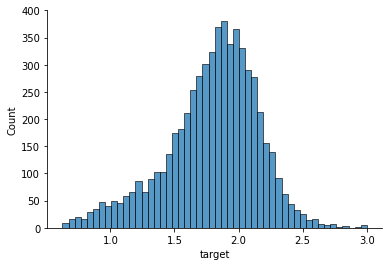

In [ ]:
fig = plt.figure()
if not (REGRESSION and TARGET == 'target'):
    sns.countplot(data=test, x='target')
else:
    sns.histplot(data=test, x='target')
sns.despine()
fig.savefig(os.path.join(output_dir, 'prediction.png'))
logger.debug('Write figure to {}'.format(os.path.join(output_dir, 'prediction.png')))

In [ ]:
logger.debug('Complete ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-20 21:32:33,141 - __main__ - DEBUG - Complete (6003.493 seconds passed)
